In [1]:
%matplotlib inline

In [2]:
import numpy as np
import nibabel as nb
import scipy.stats as stats
import matplotlib.pyplot as plt
from nilearn.input_data import NiftiMasker
import seaborn as sns

### Load gradients and cell data

In [3]:
img = nb.load('/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_200um.nii.gz')
mask = img.get_data()
aff = img.affine
hdr = img.header

In [5]:
x = np.load('/home/julia/data/gradients/atlas/epfl_cell_atlas/x2vol_200.npy')
y = np.load('/home/julia/data/gradients/atlas/epfl_cell_atlas/y2vol_200.npy')
z = np.load('/home/julia/data/gradients/atlas/epfl_cell_atlas/z2vol_200.npy')
types = np.load('/home/julia/data/gradients/atlas/epfl_cell_atlas/types.npy')

Types probably:
0 - excitatory neurons;
1 - inhibitory neurons;
2 - oligodendrocytes;
3 - astrocytes;
4 - microglia;

### Make a cell density map

In [6]:
cell_density = np.zeros_like(mask)
for c in range(len(x)):
    voxel = (int(np.floor(x[c])), int(np.floor(y[c])), int(np.floor(z[c])))
    if not mask[voxel] == 0:
        cell_density[voxel] +=  1

In [8]:
nb.save(nb.Nifti1Image(cell_density, aff, hdr), 
        '/home/julia/data/gradients/atlas/epfl_cell_atlas/cortex_cells_200um.nii.gz')

### Apply sigmoid normalization

In [4]:
cell_density = nb.load('/home/julia/data/gradients/atlas/epfl_cell_atlas/cortex_cells_200um.nii.gz').get_data()

In [5]:
def sigmoid(energy):
    X = (energy - np.mean(energy)) / np.std(energy)
    sig = 1 / (1 + np.exp(-X))
    return sig

(array([ 732., 1086., 6129., 6069., 1324.,   37.,   16.,   10.,    7.,
          12.]),
 array([   0. ,  421.5,  843. , 1264.5, 1686. , 2107.5, 2529. , 2950.5,
        3372. , 3793.5, 4215. ], dtype=float32),
 <a list of 10 Patch objects>)

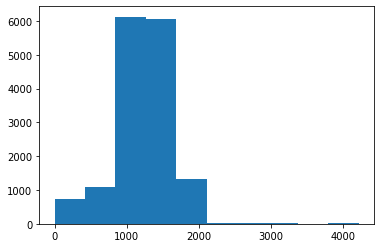

In [8]:
plt.hist(cell_density[mask==1])

(array([ 909.,  652.,  983., 2355., 3232., 2279., 2602., 1840.,  493.,
          77.]),
 array([0.04160001, 0.13738483, 0.23316966, 0.3289545 , 0.4247393 ,
        0.52052414, 0.6163089 , 0.7120938 , 0.8078786 , 0.9036634 ,
        0.99944824], dtype=float32),
 <a list of 10 Patch objects>)

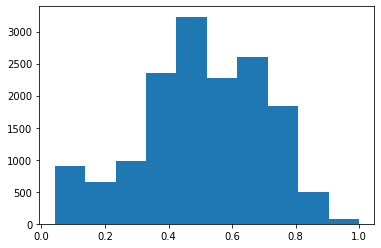

In [10]:
plt.hist(sigmoid(cell_density[mask==1]))

In [15]:
sig_density = np.zeros_like(cell_density)
sig_density[mask==1] = sigmoid(cell_density[mask==1])
nb.save(nb.Nifti1Image(sig_density, aff, hdr), 
        '/home/julia/data/gradients/atlas/epfl_cell_atlas/cortex_cells_sig_200um.nii.gz')

### Smooth cell density map with same kernel as gradient

In [17]:
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=img, standardize=False, smoothing_fwhm=0.45)
smoothed_trans = masker.fit_transform('/home/julia/data/gradients/atlas/epfl_cell_atlas/cortex_cells_sig_200um.nii.gz')

In [18]:
smoothed = masker.inverse_transform(smoothed_trans)
smoothed.to_filename('/home/julia/data/gradients/atlas/epfl_cell_atlas/cortex_cells_sig_200um_smooth045.nii.gz')
cell_density = smoothed.get_data().squeeze()

### Calcluate Spearman correlation to gradients

In [19]:
gradients = nb.load('/home/julia/data/gradients/results/embedding_vol/embed.nii.gz').get_data()
for g in range(6):
    gradient =  gradients[:,:,:,g]
    print('Gradient %i:' %g, stats.spearmanr(cell_density[mask==1], gradient[mask==1]))

Gradient 0: SpearmanrResult(correlation=0.4133536134638217, pvalue=0.0)
Gradient 1: SpearmanrResult(correlation=-0.16091226981972953, pvalue=5.734026319963923e-90)
Gradient 2: SpearmanrResult(correlation=0.13171641994043953, pvalue=1.2149074095901342e-60)
Gradient 3: SpearmanrResult(correlation=0.10250583629724629, pvalue=2.6615698384981902e-37)
Gradient 4: SpearmanrResult(correlation=-0.39757415877784075, pvalue=0.0)
Gradient 5: SpearmanrResult(correlation=0.08582792404327717, pvalue=1.2984015981157744e-26)


### Plot

In [20]:
gradients = nb.load('/home/julia/data/gradients/results/embedding_vol/embed.nii.gz').get_data()
template = nb.load('/home/julia/data/gradients/atlas/allen_api/template_200.nii.gz').get_data()
cell_density = nb.load('/home/julia/data/gradients/atlas/epfl_cell_atlas/cortex_cells_sig_200um_smooth045.nii.gz').get_data().squeeze()
mask = nb.load('/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_200um.nii.gz').get_data()

In [21]:
cell_density[mask==0] = np.nan
gradient_0 = gradients[:,:,:,0]
gradient_0[mask==0] = np.nan
gradient_4 = gradients[:,:,:,4]
gradient_4[mask==0] = np.nan

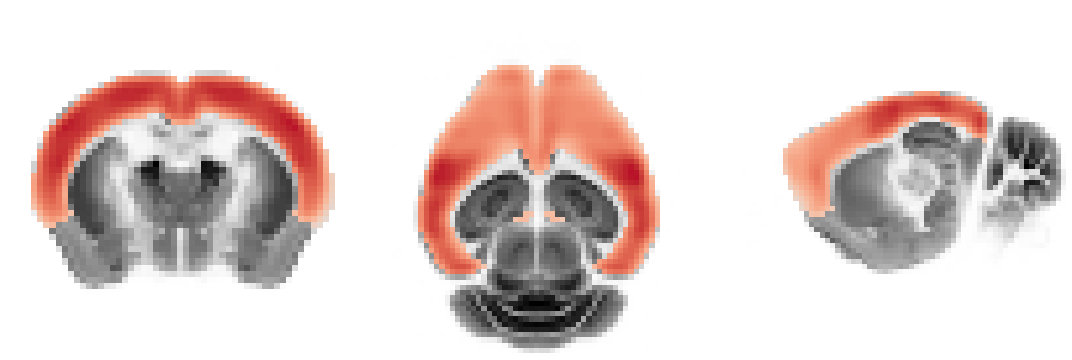

In [22]:
x=30
y=10
z=15


fig = plt.figure(figsize=(15,15))

vmin = -max(np.abs(np.nanmin(cell_density)), np.abs(np.nanmax(cell_density)))
vmax = max(np.abs(np.nanmin(cell_density)), np.abs(np.nanmax(cell_density)))

fig.add_subplot(3,3,1)
plt.imshow(template[x,:,:],  cmap='Greys', aspect='equal');
plt.imshow(cell_density[x,:,:],  cmap="coolwarm", aspect='equal', vmin=vmin, vmax=vmax);
plt.axis('off');

fig.add_subplot(3,3,2)
plt.imshow(template[:,y,:],  cmap='Greys', aspect='equal');
plt.imshow(cell_density[:,y,:],  cmap="coolwarm", aspect='equal', vmin=vmin, vmax=vmax);
plt.axis('off');

fig.add_subplot(3,3,3)
plt.imshow(template[:,:,z].T,  cmap='Greys', aspect='equal');
plt.imshow(cell_density[:,:,z].T,  cmap="coolwarm", aspect='equal', vmin=vmin, vmax=vmax);
plt.axis('off');

# vmin = np.nanmin(gradient_0)
# vmax = np.nanmax(gradient_0)

# fig.add_subplot(3,3,4)
# plt.imshow(template[x,:,:],  cmap='Greys', aspect='equal');
# plt.imshow(gradient_0[x,:,:],  cmap="cubehelix", aspect='equal', vmin=vmin, vmax=vmax);
# plt.axis('off');

# fig.add_subplot(3,3,5)
# plt.imshow(template[:,y,:],  cmap='Greys', aspect='equal');
# plt.imshow(gradient_0[:,y,:],  cmap="cubehelix", aspect='equal', vmin=vmin, vmax=vmax);
# plt.axis('off');

# fig.add_subplot(3,3,6)
# plt.imshow(template[:,:,z].T,  cmap='Greys', aspect='equal');
# plt.imshow(gradient_0[:,:,z].T,  cmap="cubehelix", aspect='equal', vmin=vmin, vmax=vmax);
# plt.axis('off');

# vmin = np.nanmin(gradient_4)
# vmax = np.nanmax(gradient_4)

# fig.add_subplot(3,3,7)
# plt.imshow(template[x,:,:],  cmap='Greys', aspect='equal');
# plt.imshow(gradient_4[x,:,:],  cmap="cubehelix", aspect='equal', vmin=vmin, vmax=vmax);
# plt.axis('off');

# fig.add_subplot(3,3,8)
# plt.imshow(template[:,y,:],  cmap='Greys', aspect='equal');
# plt.imshow(gradient_4[:,y,:],  cmap="cubehelix", aspect='equal', vmin=vmin, vmax=vmax);
# plt.axis('off');

# fig.add_subplot(3,3,9)
# plt.imshow(template[:,:,z].T,  cmap='Greys', aspect='equal');
# plt.imshow(gradient_4[:,:,z].T,  cmap="cubehelix", aspect='equal', vmin=vmin, vmax=vmax);
# plt.axis('off');

plt.tight_layout()